## Import libraries and dataset

In [1]:
! pip install nltk
! pip install yellowbrick
! pip install umap-learn
! pip install plotly
! pip install pyLDAvis
! pip install pyyaml==5.4.1
! pip install tensorflow tensorflow_hub
! pip install sentence-transformers
! pip install chromadb

seed=42

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Get

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import re
import nltk
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import chromadb
from chromadb.utils import embedding_functions

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
drive.mount('/content/gdrive')
file_path = '/content/gdrive/My Drive/Colab Notebooks/dataset/'

# read csv
try:
    data = pd.read_csv(file_path+'all-data.csv', header=None)
    data.columns = ['sentiment', 'text']
    print("File caricato con successo!")
except FileNotFoundError:
    print("Il file non è stato trovato. Assicurati che il percorso sia corretto.")

Mounted at /content/gdrive
File caricato con successo!


In [4]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
data.shape

(4846, 2)

## Data Storage and Query

### Tokenization

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]
    lower_text = text.lower()                                              # Converting all words into lower case.
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()   # Replacing all characters except those in the pattern into spaces.
    filtered_text = word_tokenize(filtered_text)                            # tokenizethe whole book into words in a list.
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    #return filtered_text
    return ' '.join(filtered_text)

In [ ]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))

In [ ]:
data.head()

,sentiment,text,cleaned_text
0,neutral,"According to Gran , the company has no plans t...",accord gran company plan move production russi...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company increase capacity...
4,positive,According to the company 's updated strategy f...,accord company update strategy year basware ta...


### Transformer encoding

**Model Choice: ProsusAI/FinBERT**

We chose ProsusAI/FinBERT for this sentiment analysis task based on its **specialized design for financial text**. FinBERT, developed by ProsusAI, is a pre-trained transformer-based model specifically fine-tuned on financial data, making it particularly suited for processing and understanding financial documents. This model has been trained to capture financial semantics, which is crucial when analyzing sentiment in financial news and reports.
Why ProsusAI/FinBERT was Chosen:

- Financial Domain Expertise: FinBERT is fine-tuned on a large corpus of financial text, which includes reports, earnings calls, and news articles. It is designed to understand financial terminology, jargon, and the nuances of sentiment in financial contexts, making it ideal for our dataset.

- Sentiment Analysis Performance: FinBERT has shown excellent performance in tasks like sentiment classification and opinion mining in the finance domain. This ensures that it can accurately identify sentiments, such as positive, negative, or neutral, within financial statements.

- Pretrained on Relevant Data: Since our dataset consists of 4,837 sentences from English language financial news categorized by sentiment, using a model trained on financial text ensures better accuracy and understanding of the contextual meaning of each sentence.

- State-of-the-Art Performance: As a BERT-based model, FinBERT is highly effective at capturing the contextual relationships between words, which improves sentiment analysis accuracy compared to traditional models. This helps the system make more nuanced predictions, especially in the complex financial domain.

Dataset Description:

The dataset used in this system is the financial_phrasebank, which consists of 4,837 sentences sourced from English language financial news articles. These sentences are categorized into different sentiment classes (e.g., positive, negative, neutral), providing a solid basis for sentiment analysis in financial contexts.

The ProsusAI/FinBERT model is ideally suited to process this dataset and extract meaningful insights from the text by accurately identifying the sentiment of each sentence in the financial news articles.

In [ ]:
# load FinBERT model
finbert_model = SentenceTransformer('ProsusAI/finbert')

# generate embedding for each doc
data['embedding_finbert'] = data['text'].apply(lambda x: finbert_model.encode(x))

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
data.head()

,sentiment,text,cleaned_text,embedding_finbert
0,neutral,"According to Gran , the company has no plans t...",accord gran company plan move production russi...,"[0.14154564, 0.26167166, -0.18762684, -0.31182..."
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...,"[0.22935009, 0.5723092, -0.0477439, -0.4229858..."
2,negative,The international electronic industry company ...,international electronic industry company elco...,"[-0.037371546, 0.4616523, -0.12549847, -0.4262..."
3,positive,With the new production plant the company woul...,new production plant company increase capacity...,"[0.22638226, 0.32406285, 0.09691923, 0.0111470..."
4,positive,According to the company 's updated strategy f...,accord company update strategy year basware ta...,"[-0.39680624, 0.5497725, 0.6312332, -0.2966155..."


In [ ]:
data['embedding_finbert'].iloc[0].shape

(768,)

### ChromaDB creation and population

In [ ]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDB"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

[Collection(name=sentiment_embeddings)]


In [ ]:
from chromadb.utils import embedding_functions

In [ ]:
from chromadb.config import Settings

# onizialie ChromaDB client
client = chromadb.PersistentClient(
    path=pathDB,  # persistence directory
)

# create ChromaDB collection
collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)

# load data into collection
for index, row in data.iterrows():
    collection.add(
        ids=[str(index)],  # unique id creation
        documents=[row["text"]],
        metadatas=[{
            "sentiment": row["sentiment"],
            "cleaned_text": row["cleaned_text"]
        }],
        embeddings=[row["embedding_finbert"]]  # embedding
    )

print("Dataset caricato in ChromaDB con successo!")

Dataset caricato in ChromaDB con successo!


### ChromaDB queries

In [6]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDB"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)

[Collection(name=sentiment_embeddings)]


In [7]:
# function to perform a search query
finbert_model = SentenceTransformer('ProsusAI/finbert')

def search_query(collection, query_text, n_results=3):
    # create embedding for the query using FinBERT
    query_embedding = finbert_model.encode(query_text)

    # perform the search
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )

    return results

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
# list of queries
queries = [
    "Silicon Valley's impact on global technology development",
    "Positive solutions in renewable energy",
    "Negative controversies in the automotive industry",
    "Political tensions in Asia-Pacific region",
    "Positive news in the stock market",
    "Issues regarding cybersecurity threats in the financial sector",
    "Celebrity endorsements positively influence brand equity"
]

# dictionary to store results
query_results = {}

# perform searches and store results
for query in queries:
    print(f"\nQuery: {query}")
    results = search_query(collection, query, n_results=3)  # fetch top 3 results

    # initialize the list to store results for this query
    query_results[query] = []

    # check if results are available
    if 'documents' in results and results['documents']:
        for i, document in enumerate(results['documents']):
            # get the metadata corresponding to the document
            metadata_list = results['metadatas'][i]
            distances = results['distances'][i]

            if isinstance(metadata_list, list):
                for j, metadata in enumerate(metadata_list):
                    # extract the necessary information
                    entry = {
                        "text": document[j],
                        "sentiment": metadata.get('sentiment', 'No sentiment found'),
                        "cleaned_text": metadata.get('cleaned_text', 'No cleaned text found')
                    }
                    query_results[query].append(entry) #add to a dict

                    # print the document, text and metadata
                    print(f"\nDocument {j + 1}:")
                    print(f"Text: {entry['text']}")
                    print(f"Sentiment: {entry['sentiment']}")
                    print(f"Cleaned Text: {entry['cleaned_text']}")
                    print(f"Distance: {distances[j]:.4f}")
                    print("-" * 50)
            else:
                print(f"Metadata for document {i + 1} is not a list. Skipping...")
    else:
        print("No relevant documents found for this query.")


Query: Silicon Valley's impact on global technology development

Document 1:
Text: `` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .
Sentiment: neutral
Cleaned Text: marimekko operates industry change business climate reflect consumer demand
Distance: 74.4567
--------------------------------------------------

Document 2:
Text: `` Our research shows that access to information technology has been one of the limiting factors for most small businesses especially when they work in a heterogenous network based environment .
Sentiment: neutral
Cleaned Text: research show access information technology one limit factor small business especially work heterogenous network base environment
Distance: 75.0527
--------------------------------------------------

Document 3:
Text: The Apple Inc. iPhone wo n't change the game plan for Verizon Communications Inc. , Chief Executive Ivan Seidenberg said Wednesday .
Sentiment: neutral
Cleaned 

## Sentiment Classification

In [9]:
for query in queries:
    print(query_results[query])

[{'text': '`` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .', 'sentiment': 'neutral', 'cleaned_text': 'marimekko operates industry change business climate reflect consumer demand'}, {'text': '`` Our research shows that access to information technology has been one of the limiting factors for most small businesses especially when they work in a heterogenous network based environment .', 'sentiment': 'neutral', 'cleaned_text': 'research show access information technology one limit factor small business especially work heterogenous network base environment'}, {'text': "The Apple Inc. iPhone wo n't change the game plan for Verizon Communications Inc. , Chief Executive Ivan Seidenberg said Wednesday .", 'sentiment': 'neutral', 'cleaned_text': 'apple inc iphone wo n change game plan verizon communication inc chief executive ivan seidenberg say wednesday'}]
[{'text': "`` Fixed Mobile Convergence solutions represent a key value pr

In [ ]:
# DA BUTTARE MA CAPIRE SE CAMBIARE TOKENIZER E MODELLO SOPRA
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",
             "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.",
             "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.",
             ]
results = nlp(sentences)
print(results)

[{'label': 'positive', 'score': 0.9998133778572083},
 {'label': 'neutral', 'score': 0.9997822642326355},
 {'label': 'negative', 'score': 0.9877365231513977}]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'positive', 'score': 0.9998133778572083}, {'label': 'neutral', 'score': 0.9997822642326355}, {'label': 'negative', 'score': 0.9877365231513977}]


[{'label': 'positive', 'score': 0.9998133778572083},
 {'label': 'neutral', 'score': 0.9997822642326355},
 {'label': 'negative', 'score': 0.9877365231513977}]

In [12]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDB"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

[Collection(name=sentiment_embeddings)]


In [15]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# initialize models
finbert_model = SentenceTransformer('ProsusAI/finbert')
sentiment_classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [16]:
actual_labels = []
predicted_labels = []

# function to classify sentiment
def classify_sentiment(text):
    result = sentiment_classifier(text)[0]  # get the first result (Hugging Face returns a list)
    return result['label'], result['score']

# process each query and classify the sentiment of the documents
for query in query_results:
    print(f"\nQuery: {query}")

    # get the results (documents) for the current query
    results = query_results[query]

    # process each document in the results
    for i, document in enumerate(results):
        text = document['text']

        # classify sentiment using the Hugging Face model
        classified_sentiment, score = classify_sentiment(text)

        actual_labels.append(document['sentiment'])
        predicted_labels.append(classified_sentiment.lower())

        # print out the results
        print(f"Top {i + 1} document:")
        print(f"Text: {text}")
        print(f"Predicted Sentiment: {classified_sentiment}")
        print(f"Score: {score}")
        print(f"Actual Sentiment: {document['sentiment']}")
        print(f"Cleaned Text: {document['cleaned_text']}")
        print("-" * 50)


Query: Silicon Valley's impact on global technology development
Top 1 document:
Text: `` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand .
Predicted Sentiment: neutral
Score: 0.9998928308486938
Actual Sentiment: neutral
Cleaned Text: marimekko operates industry change business climate reflect consumer demand
--------------------------------------------------
Top 2 document:
Text: `` Our research shows that access to information technology has been one of the limiting factors for most small businesses especially when they work in a heterogenous network based environment .
Predicted Sentiment: negative
Score: 0.9955581426620483
Actual Sentiment: neutral
Cleaned Text: research show access information technology one limit factor small business especially work heterogenous network base environment
--------------------------------------------------
Top 3 document:
Text: The Apple Inc. iPhone wo n't change the game plan for Verizon 

In [17]:
actual_labels[:3], predicted_labels[:3]

(['neutral', 'neutral', 'neutral'], ['neutral', 'negative', 'neutral'])

In [18]:
# confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'])

# classification report
report = classification_report(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'], zero_division=1)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    positive       0.67      1.00      0.80         4
     neutral       1.00      0.56      0.71         9
    negative       0.80      1.00      0.89         8

    accuracy                           0.81        21
   macro avg       0.82      0.85      0.80        21
weighted avg       0.86      0.81      0.80        21



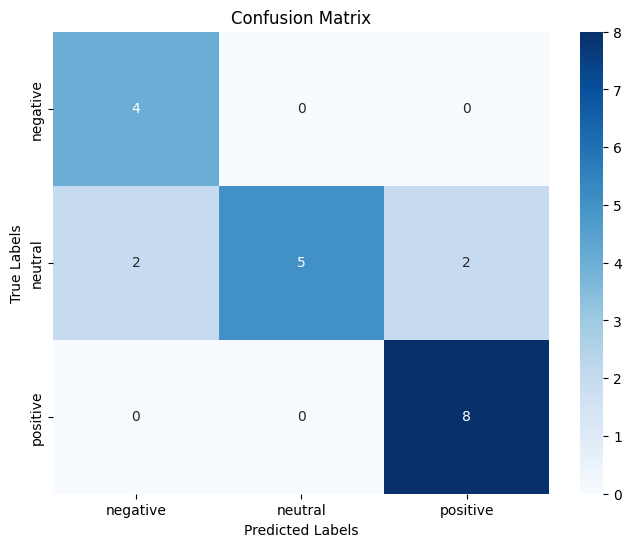

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()